<a href="https://colab.research.google.com/github/vkacabaca/vkacabaca/blob/main/EDA-%20preprocessing%20Accident%20Severity%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** UK road safety**





In [ ]:
!pip install dask

In [ ]:
import time

def time_step(fn):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = fn(*args, **kwargs)
        end_time = time.time()
        time_taken = round(end_time - start_time, 4)
        if time_taken < 60:
            print(f'{fn.__name__} took {time_taken} seconds to run')
        else:
            print(f'{fn.__name__} took {time_taken / 60} minutes to run')
        return result
    return wrapper

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Library for Data Preprocessing and Cleaning
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.impute import KNNImputer

1. Business problem:

Using data from the first quarter, the car insurance company aims to develop a predictive model to assess the severity of accidents for drivers applying for insurance. The goal is to use key variables to identify high-risk drivers and adjust premiums accordingly. By accurately predicting accident severity, the company can make more informed decisions, improve underwriting processes, and offer competitive yet profitable insurance premiums.

2. Objectives

- Predict Accident Severity: Predict Accident Severity:
Develop a classification model where accident severity is categorized into three levels (1: Low, 2: Medium, 3: High).
Use various machine learning algorithms to determine the most accurate model.
Evaluate the model's performance using metrics such as accuracy, precision, recall, and F1 score.
- Identify High-Risk Drivers: Use the model’s predictions to identify drivers who have a higher likelihood of being involved in severe accidents.
Implement risk stratification to group drivers into different risk categories (e.g., low, medium, high).
3. Data Preparation:

Here, we have 3 data sets for 2022 road safety. First, we will load the datasets and merge it all together then join them by the "accident_index" row. And then we only take the first quarter of the data from 01/01/2022 to 31/03/2022.


In [ ]:
# Load the datasets
casualty_data = pd.read_csv('/content/dft-road-casualty-statistics-casualty-2022.csv',low_memory = False)
collision_data = pd.read_csv('/content/dft-road-casualty-statistics-collision-2022.csv',low_memory = False)
vehicle_data = pd.read_csv('/content/dft-road-casualty-statistics-vehicle-2022.csv',low_memory = False)


In [ ]:
# Check data types of key columns
print(casualty_data[['accident_index']].dtypes)
print(collision_data[['accident_index']].dtypes)
print(vehicle_data[['accident_index', 'vehicle_reference']].dtypes)

accident_index    object
dtype: object
accident_index    object
dtype: object
accident_index       object
vehicle_reference     int64
dtype: object


In [ ]:
# Check unique accident_index values in each dataset
casualty_unique_accidents = set(casualty_data['accident_index'].unique())
collision_unique_accidents = set(collision_data['accident_index'].unique())
vehicle_unique_accidents = set(vehicle_data['accident_index'].unique())

# Find common accident_index values
common_accident_index = casualty_unique_accidents.intersection(collision_unique_accidents).intersection(vehicle_unique_accidents)

print("Unique accident_index in casualty_data:", len(casualty_unique_accidents))
print("Unique accident_index in collision_data:", len(collision_unique_accidents))
print("Unique accident_index in vehicle_data:", len(vehicle_unique_accidents))
print("Number of common accident_index values:", len(common_accident_index))

Unique accident_index in casualty_data: 106004
Unique accident_index in collision_data: 106004
Unique accident_index in vehicle_data: 106004
Number of common accident_index values: 106004


In [ ]:
casualty_data.head()

,accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,lsoa_of_casualty
0,2022010352073,2022,010352073,2,1,1,1,17,4,3,0,0,0,0,0,3,1,1,E01001364
1,2022010352573,2022,010352573,1,1,1,2,42,7,3,0,0,0,0,0,9,1,5,E01000338
2,2022010352575,2022,010352575,1,1,1,1,20,4,3,0,0,0,0,0,9,1,8,E01000390
3,2022010352578,2022,010352578,1,1,1,1,46,8,3,0,0,0,0,0,9,1,3,E01004666
4,2022010352578,2022,010352578,1,2,2,1,45,7,3,0,0,1,0,0,9,1,3,E01004666


In [ ]:
# remove the duplicates
casualty_data.drop_duplicates(inplace=True)

In [ ]:
casualty_data.shape

(135480, 19)

In [ ]:
collision_data.head()

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2022010352073,2022,010352073,525199.0,177928.0,-0.198224,51.486454,1,3,2,...,0,4,1,1,0,0,1,1,2,E01001883
1,2022010352573,2022,010352573,546214.0,179866.0,0.105042,51.498830,1,3,2,...,4,4,1,1,0,0,2,1,2,E01033745
2,2022010352575,2022,010352575,551119.0,174789.0,0.173482,51.451924,1,3,2,...,0,4,1,1,0,0,1,1,2,E01000378
3,2022010352578,2022,010352578,528889.0,192230.0,-0.139873,51.614153,1,3,2,...,0,4,1,1,0,0,1,1,2,E01001529
4,2022010352580,2022,010352580,539773.0,190404.0,0.016495,51.595151,1,3,4,...,0,4,1,1,0,0,1,1,2,E01003673


In [ ]:
# remove the duplicates
collision_data.drop_duplicates(inplace=True)

In [ ]:
collision_data.shape

(106004, 36)

In [ ]:
vehicle_data.head()

,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,...,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type,lsoa_of_driver
0,2022010352073,2022,010352073,1,19,0,9,3,8,0,...,1,48,8,1461,2,4,RENAULT KANGOO,7,1,E01002687
1,2022010352073,2022,010352073,2,3,0,18,1,5,0,...,1,17,4,125,1,1,HONDA FSH125,1,1,E01001364
2,2022010352573,2022,010352573,1,9,0,18,7,3,0,...,2,42,7,-1,-1,-1,-1,5,1,E01000338
3,2022010352573,2022,010352573,2,9,0,13,7,3,0,...,3,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,2022010352575,2022,010352575,1,9,0,18,4,8,0,...,1,20,4,1896,2,15,VOLKSWAGEN GOLF,8,1,E01000390


In [ ]:
# remove the duplicates
vehicle_data.drop_duplicates(inplace=True)

In [ ]:
vehicle_data.shape

(193545, 28)

In [ ]:
# Merge datasets on 'accident_index'
merged_data = pd.merge(casualty_data, collision_data, on='accident_index', how='inner')
merged_data = pd.merge(merged_data, vehicle_data, on=['accident_index', 'vehicle_reference'], how='inner')

# Display the first few rows of the merged dataset
merged_data_head = merged_data.head()
merged_data_head


,accident_index,accident_year_x,accident_reference_x,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,...,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type,lsoa_of_driver
0,2022010352073,2022,010352073,2,1,1,1,17,4,3,...,1,17,4,125,1,1,HONDA FSH125,1,1,E01001364
1,2022010352573,2022,010352573,1,1,1,2,42,7,3,...,2,42,7,-1,-1,-1,-1,5,1,E01000338
2,2022010352575,2022,010352575,1,1,1,1,20,4,3,...,1,20,4,1896,2,15,VOLKSWAGEN GOLF,8,1,E01000390
3,2022010352578,2022,010352578,1,1,1,1,46,8,3,...,1,46,8,2993,2,2,BMW 5 SERIES,3,1,E01004666
4,2022010352578,2022,010352578,1,2,2,1,45,7,3,...,1,46,8,2993,2,2,BMW 5 SERIES,3,1,E01004666


In [ ]:
merged_data.shape

(135480, 80)

In [ ]:
# Display the info of the data set
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135480 entries, 0 to 135479
Data columns (total 80 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               135480 non-null  object 
 1   accident_year_x                              135480 non-null  int64  
 2   accident_reference_x                         135480 non-null  object 
 3   vehicle_reference                            135480 non-null  int64  
 4   casualty_reference                           135480 non-null  int64  
 5   casualty_class                               135480 non-null  int64  
 6   sex_of_casualty                              135480 non-null  int64  
 7   age_of_casualty                              135480 non-null  int64  
 8   age_band_of_casualty                         135480 non-null  int64  
 9   casualty_severity                            135480 non-nul

In [ ]:
# Convert 'date' to datetime format
merged_data['date'] = pd.to_datetime(merged_data['date'], format='%d/%m/%Y', errors='coerce')

# Filter data for the first quarter (January to March)
first_quarter = merged_data[(merged_data['date'].dt.month >= 1) &
                                              (merged_data['date'].dt.month <= 3)]

# Display the first few rows of the filtered dataset
first_quarter.head()

,accident_index,accident_year_x,accident_reference_x,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,...,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type,lsoa_of_driver
0,2022010352073,2022,010352073,2,1,1,1,17,4,3,...,1,17,4,125,1,1,HONDA FSH125,1,1,E01001364
1,2022010352573,2022,010352573,1,1,1,2,42,7,3,...,2,42,7,-1,-1,-1,-1,5,1,E01000338
2,2022010352575,2022,010352575,1,1,1,1,20,4,3,...,1,20,4,1896,2,15,VOLKSWAGEN GOLF,8,1,E01000390
3,2022010352578,2022,010352578,1,1,1,1,46,8,3,...,1,46,8,2993,2,2,BMW 5 SERIES,3,1,E01004666
4,2022010352578,2022,010352578,1,2,2,1,45,7,3,...,1,46,8,2993,2,2,BMW 5 SERIES,3,1,E01004666


In [ ]:
first_quarter.shape

(32404, 80)

In [ ]:
# Inspect columns in the data to identify all the columns
first_quarter.columns

Index(['accident_index', 'accident_year_x', 'accident_reference_x',
       'vehicle_reference', 'casualty_reference', 'casualty_class',
       'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty',
       'casualty_severity', 'pedestrian_location', 'pedestrian_movement',
       'car_passenger', 'bus_or_coach_passenger',
       'pedestrian_road_maintenance_worker', 'casualty_type',
       'casualty_home_area_type', 'casualty_imd_decile', 'lsoa_of_casualty',
       'accident_year_y', 'accident_reference_y', 'location_easting_osgr',
       'location_northing_osgr', 'longitude', 'latitude', 'police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'date', 'day_of_week', 'time', 'local_authority_district',
       'local_authority_ons_district', 'local_authority_highway',
       'first_road_class', 'first_road_number', 'road_type', 'speed_limit',
       'junction_detail', 'junction_control', 'second_road_class',
       'second_road_number', 'pede

In [ ]:
# Select key variables
key_columns = [    'accident_severity','age_of_driver','sex_of_driver',
               'vehicle_type', 'vehicle_manoeuvre', 'vehicle_direction_from',
                   'vehicle_direction_to', 'junction_location',
                   'speed_limit', 'road_surface_conditions',  'engine_capacity_cc',
                   'journey_purpose_of_driver', 'casualty_class','junction_detail',
                   'driver_imd_decile','age_of_vehicle','driver_home_area_type', 'number_of_vehicles', 'number_of_casualties', 'casualty_severity' ]
df = first_quarter[key_columns]
# Display the first few rows of the selected dataset
df.head()

,accident_severity,age_of_driver,sex_of_driver,vehicle_type,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,junction_location,speed_limit,road_surface_conditions,engine_capacity_cc,journey_purpose_of_driver,casualty_class,junction_detail,driver_imd_decile,age_of_vehicle,driver_home_area_type,number_of_vehicles,number_of_casualties,casualty_severity
0,3,17,1,3,18,1,5,1,30,1,125,2,1,6,1,1,1,2,1,3
1,3,42,2,9,18,7,3,6,50,1,-1,6,1,6,5,-1,1,2,1,3
2,3,20,1,9,18,4,8,2,30,1,1896,6,1,9,8,15,1,2,1,3
3,3,46,1,9,4,1,5,0,30,1,2993,1,1,0,3,2,1,2,2,3
4,3,46,1,9,4,1,5,0,30,1,2993,1,2,0,3,2,1,2,2,3


In [ ]:
df.head()

,accident_severity,age_of_driver,sex_of_driver,vehicle_type,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,junction_location,speed_limit,road_surface_conditions,engine_capacity_cc,journey_purpose_of_driver,casualty_class,junction_detail,driver_imd_decile,age_of_vehicle,driver_home_area_type,number_of_vehicles,number_of_casualties,casualty_severity
0,3,17,1,3,18,1,5,1,30,1,125,2,1,6,1,1,1,2,1,3
1,3,42,2,9,18,7,3,6,50,1,-1,6,1,6,5,-1,1,2,1,3
2,3,20,1,9,18,4,8,2,30,1,1896,6,1,9,8,15,1,2,1,3
3,3,46,1,9,4,1,5,0,30,1,2993,1,1,0,3,2,1,2,2,3
4,3,46,1,9,4,1,5,0,30,1,2993,1,2,0,3,2,1,2,2,3


# Missing value

In [ ]:
missing_value_label = -1

# Replace -1 with NaN for easier handling, and make a copy set to avoid data copywarning
df = df.copy()
df.replace(missing_value_label, np.nan, inplace=True)

In [ ]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

accident_severity               0
age_of_driver                1763
sex_of_driver                   0
vehicle_type                   14
vehicle_manoeuvre             287
vehicle_direction_from        516
vehicle_direction_to          518
junction_location             121
speed_limit                     0
road_surface_conditions       185
engine_capacity_cc           7870
journey_purpose_of_driver       0
casualty_class                  0
junction_detail                 0
driver_imd_decile            3805
age_of_vehicle               7587
driver_home_area_type        3643
number_of_vehicles              0
number_of_casualties            0
casualty_severity               0
dtype: int64


In [ ]:
df.dtypes

accident_severity              int64
age_of_driver                float64
sex_of_driver                  int64
vehicle_type                 float64
vehicle_manoeuvre            float64
vehicle_direction_from       float64
vehicle_direction_to         float64
junction_location            float64
speed_limit                    int64
road_surface_conditions      float64
engine_capacity_cc           float64
journey_purpose_of_driver      int64
casualty_class                 int64
junction_detail                int64
driver_imd_decile            float64
age_of_vehicle               float64
driver_home_area_type        float64
number_of_vehicles             int64
number_of_casualties           int64
casualty_severity              int64
dtype: object

In [ ]:
# Define features and target variable
X = df.drop(columns=['accident_severity'])
y = df['accident_severity']

# Split the data into training and testing sets
trainset, testset = train_test_split(df, test_size=0.2, random_state=7)
print(f"{trainset.shape[0]} training and {testset.shape[0]} test instances")

25923 training and 6481 test instances


In [ ]:
trainset.describe()

,accident_severity,age_of_driver,sex_of_driver,vehicle_type,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,junction_location,speed_limit,road_surface_conditions,engine_capacity_cc,journey_purpose_of_driver,casualty_class,junction_detail,driver_imd_decile,age_of_vehicle,driver_home_area_type,number_of_vehicles,number_of_casualties,casualty_severity
count,25923.000000,24537.000000,25923.000000,25916.000000,25693.000000,25515.000000,25514.000000,25826.000000,25923.000000,25781.000000,19656.000000,25923.000000,25923.000000,25923.000000,22889.000000,19881.000000,23016.000000,25923.000000,25923.000000,25923.000000
mean,2.734097,40.001712,1.395710,9.810658,19.536878,4.544190,4.610802,2.531828,37.196312,1.443776,1626.714489,4.561278,1.501177,3.815878,4.949146,8.722247,1.294534,1.892682,1.630830,2.789723
std,0.486058,16.704432,0.567584,12.603400,22.034429,2.562344,2.545700,3.301221,14.683120,0.956010,1221.292410,1.915197,0.750966,11.988348,2.795525,5.640042,0.650084,0.759972,1.140454,0.439574
min,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.000000,1.000000,48.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,27.000000,1.000000,9.000000,9.000000,2.000000,2.000000,0.000000,30.000000,1.000000,1199.000000,2.000000,1.000000,0.000000,3.000000,4.000000,1.000000,1.000000,1.000000,3.000000
50%,3.000000,37.000000,1.000000,9.000000,18.000000,5.000000,5.000000,1.000000,30.000000,1.000000,1499.000000,6.000000,1.000000,2.000000,5.000000,8.000000,1.000000,2.000000,1.000000,3.000000
75%,3.000000,51.000000,2.000000,9.000000,18.000000,7.000000,7.000000,5.000000,40.000000,2.000000,1968.000000,6.000000,2.000000,3.000000,7.000000,13.000000,1.000000,2.000000,2.000000,3.000000
max,3.000000,99.000000,3.000000,99.000000,99.000000,9.000000,9.000000,9.000000,70.000000,9.000000,16400.000000,6.000000,3.000000,99.000000,10.000000,122.000000,3.000000,16.000000,16.000000,3.000000


Descriptive statistics for the trainset can be inspected here. For example, the average age of a driver who has had an incident is 40 years of age.

In [ ]:
trainset.mode()

,accident_severity,age_of_driver,sex_of_driver,vehicle_type,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,junction_location,speed_limit,road_surface_conditions,engine_capacity_cc,journey_purpose_of_driver,casualty_class,junction_detail,driver_imd_decile,age_of_vehicle,driver_home_area_type,number_of_vehicles,number_of_casualties,casualty_severity
0,3,30.0,1,9.0,18.0,1.0,5.0,0.0,30,1.0,1598.0,6,1,0,2.0,6.0,1.0,2,1,3


We can see the most occuring values in each column. For example, the drivers with the most occurring incidents are 30 years of age.

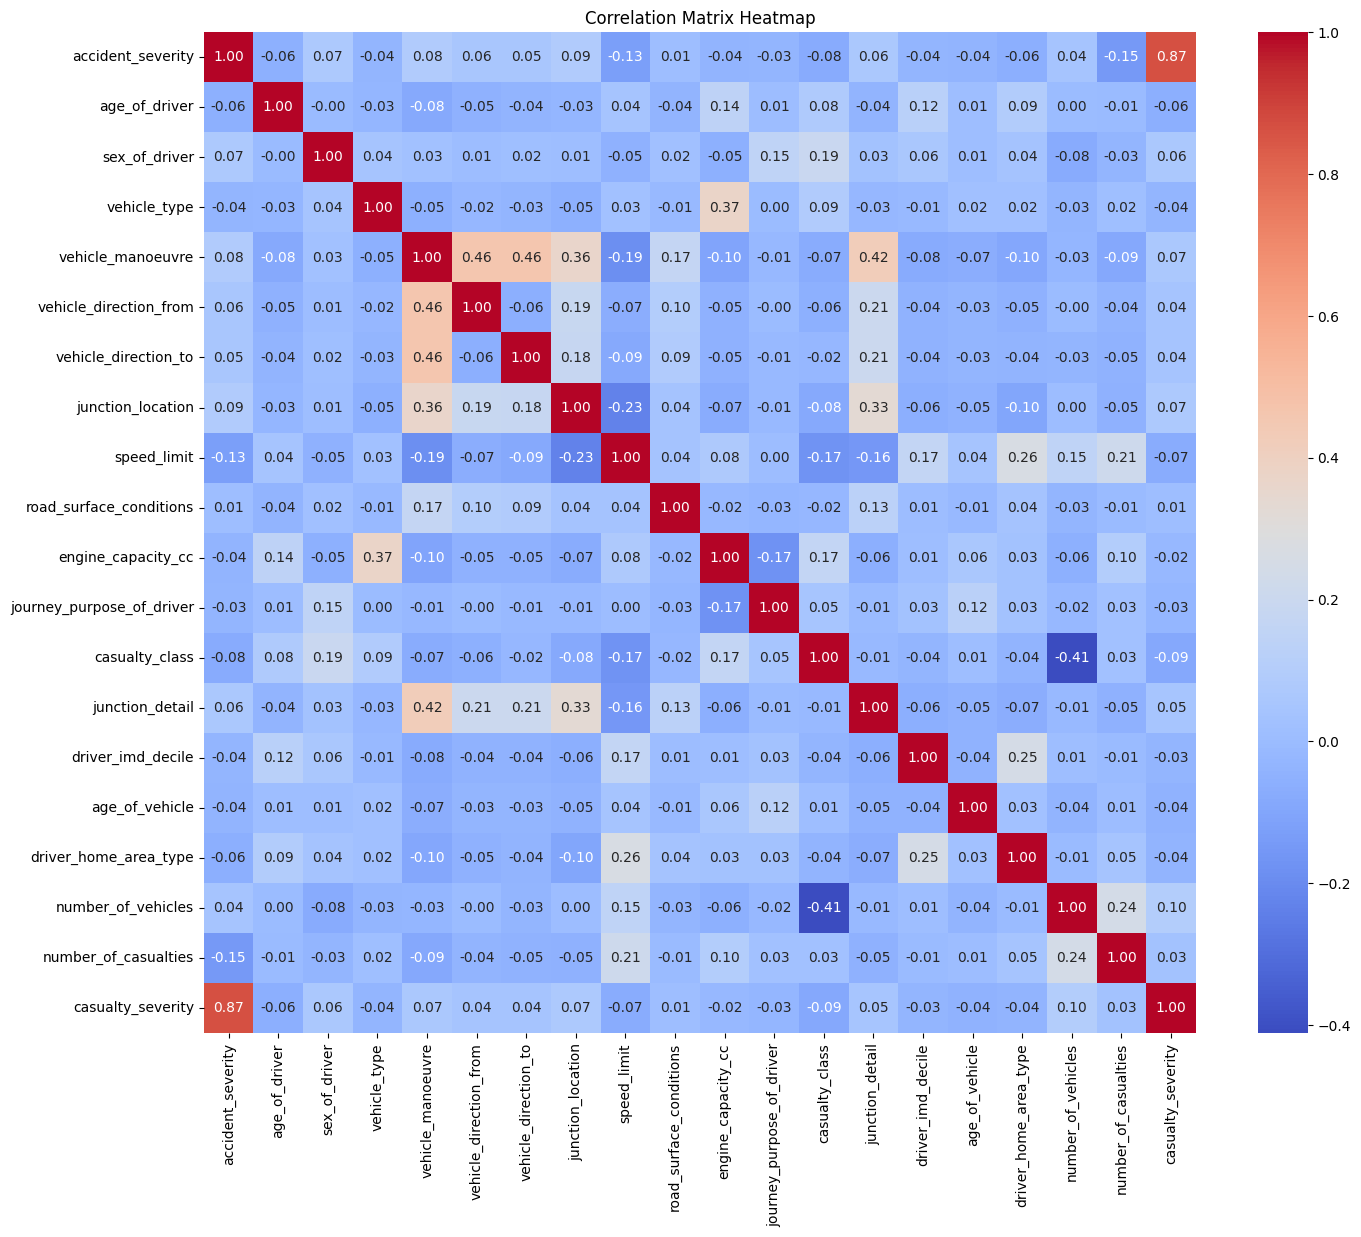

In [ ]:
corr_matrix = trainset.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 13))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Add titles and labels
plt.title('Correlation Matrix Heatmap')
plt.show()

# **4. EDA**
 **UNIVARIATE ANALYSIS**


In [ ]:
trainset.describe()

,accident_severity,age_of_driver,sex_of_driver,vehicle_type,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,junction_location,speed_limit,road_surface_conditions,engine_capacity_cc,journey_purpose_of_driver,casualty_class,junction_detail,driver_imd_decile,age_of_vehicle,driver_home_area_type,number_of_vehicles,number_of_casualties,casualty_severity
count,25923.000000,24537.000000,25923.000000,25916.000000,25693.000000,25515.000000,25514.000000,25826.000000,25923.000000,25781.000000,19656.000000,25923.000000,25923.000000,25923.000000,22889.000000,19881.000000,23016.000000,25923.000000,25923.000000,25923.000000
mean,2.734097,40.001712,1.395710,9.810658,19.536878,4.544190,4.610802,2.531828,37.196312,1.443776,1626.714489,4.561278,1.501177,3.815878,4.949146,8.722247,1.294534,1.892682,1.630830,2.789723
std,0.486058,16.704432,0.567584,12.603400,22.034429,2.562344,2.545700,3.301221,14.683120,0.956010,1221.292410,1.915197,0.750966,11.988348,2.795525,5.640042,0.650084,0.759972,1.140454,0.439574
min,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.000000,1.000000,48.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,27.000000,1.000000,9.000000,9.000000,2.000000,2.000000,0.000000,30.000000,1.000000,1199.000000,2.000000,1.000000,0.000000,3.000000,4.000000,1.000000,1.000000,1.000000,3.000000
50%,3.000000,37.000000,1.000000,9.000000,18.000000,5.000000,5.000000,1.000000,30.000000,1.000000,1499.000000,6.000000,1.000000,2.000000,5.000000,8.000000,1.000000,2.000000,1.000000,3.000000
75%,3.000000,51.000000,2.000000,9.000000,18.000000,7.000000,7.000000,5.000000,40.000000,2.000000,1968.000000,6.000000,2.000000,3.000000,7.000000,13.000000,1.000000,2.000000,2.000000,3.000000
max,3.000000,99.000000,3.000000,99.000000,99.000000,9.000000,9.000000,9.000000,70.000000,9.000000,16400.000000,6.000000,3.000000,99.000000,10.000000,122.000000,3.000000,16.000000,16.000000,3.000000


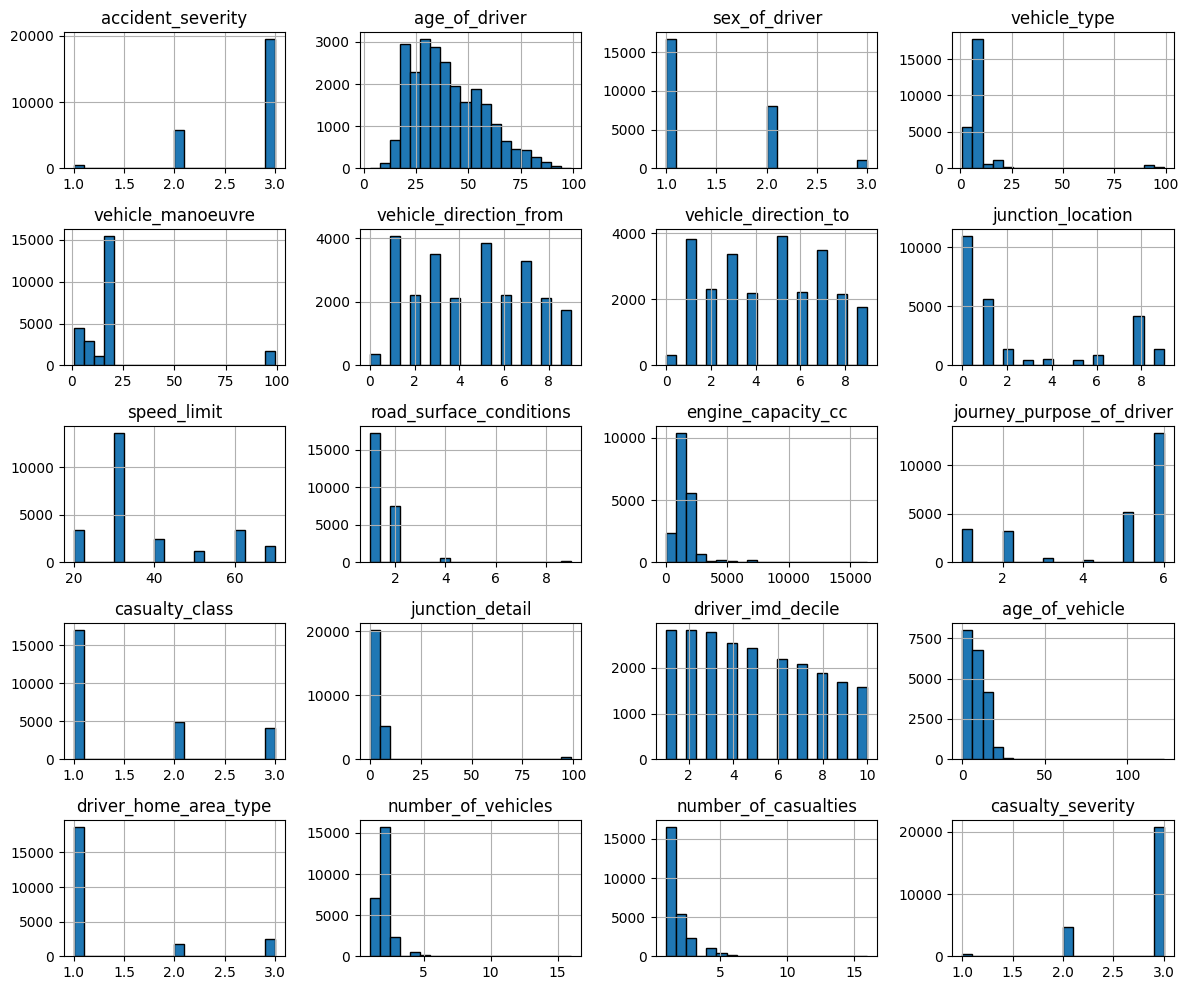

In [ ]:
# Distribution of numerical variables
trainset.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

# Distribution of categorical variables
for column in trainset.select_dtypes(include=['object', 'category']).columns:
    plt.figure(figsize=(8, 4))
    df[column].value_counts().plot(kind='bar', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.show()


accident_severity: The data is highly skewed towards the lower severity categories, indicating most accidents are slight or coded 3.

age_of_driver: The distribution is unimodal, with most drivers being between 20 and 40 years old, and a rapid decline after 50, which makes intuitive sense as there are lesser senior drivers.

sex_of_driver: The data is skewed towards one sex which is male, with the other categories: female and unknown, having much fewer occurrences.

vehicle_type: One vehicle type dominates the dataset which are cars.

vehicle_manoeuvre: Most vehicles are engaged in a specific maneuver which is going straight.

vehicle_direction_from & to, suggesting that a low number of cars were parked during the incidents, with a decent amount of collisions being head on.

junction_location: Accidents occur more frequently when there are no junctions within 20 meters.


road_surface_conditions: Most accidents occur under dry road conditions, with some at wet road conditions.

journey_purpose_of_driver: The histogram suggests a predominant journey purpose, with other purposes being much less common.


driver_imd_decile: There is a wide range of driver IMD (Index of Multiple Deprivation) deciles, with some deciles having more accidents than others.

Furthermore, Casualty severity seems to be mostly slight.


<ipython-input-33-6d49cd784160>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_manoeuvre = sns.countplot(x=trainset["vehicle_manoeuvre"], palette="viridis", order=trainset["vehicle_manoeuvre"].value_counts().index)


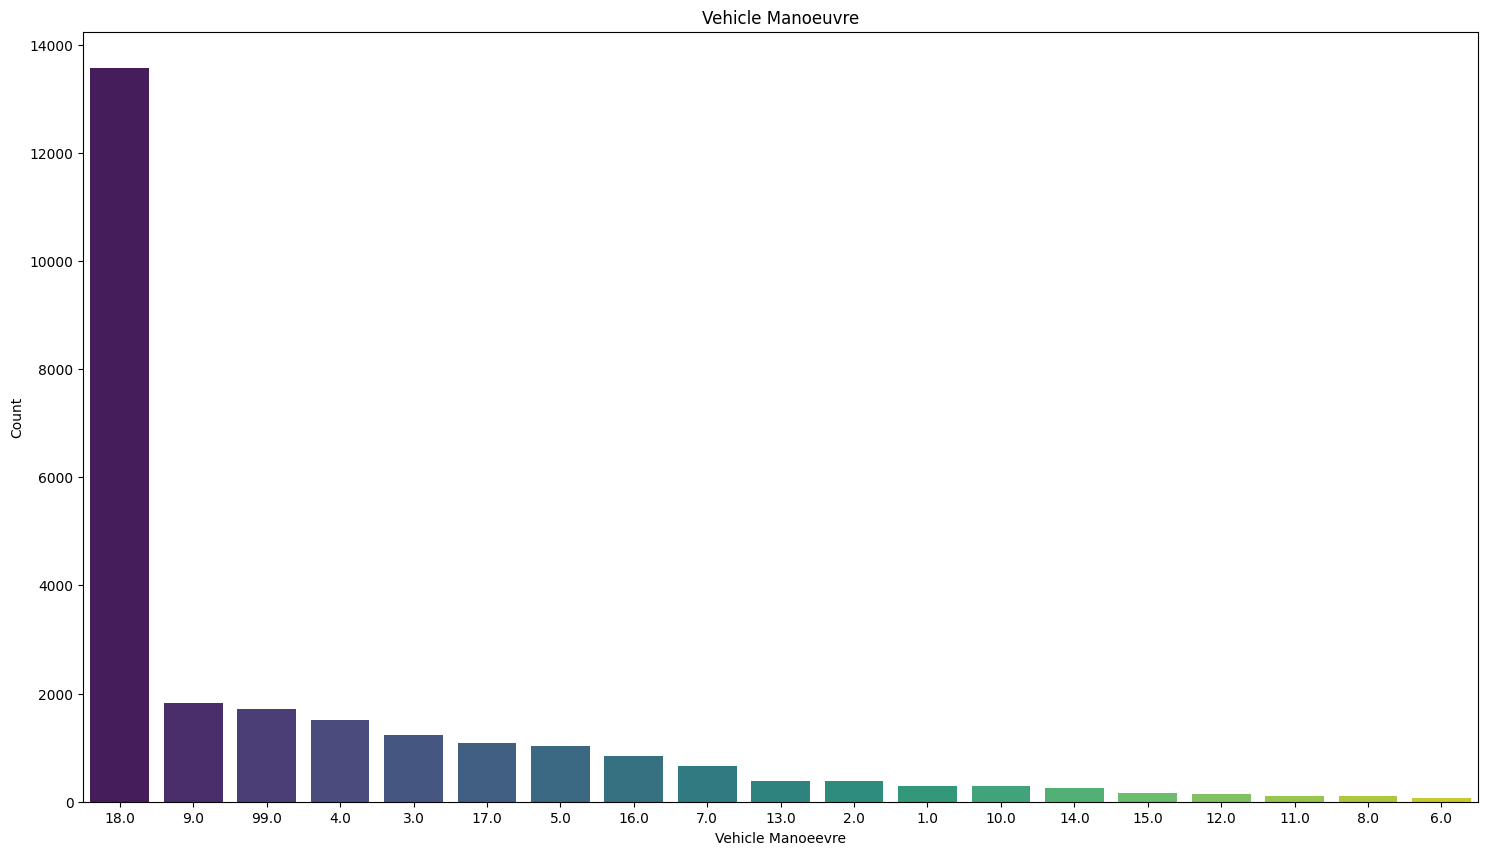

In [ ]:
# Create the countplot
plt.figure(figsize=(18, 10))  # You can adjust the width and height values as needed
plot_manoeuvre = sns.countplot(x=trainset["vehicle_manoeuvre"], palette="viridis", order=trainset["vehicle_manoeuvre"].value_counts().index)

# Rotate x-axis labels if they are too long
plt.xticks()


# Set the axis labels
plot_manoeuvre.set_xlabel("Vehicle Manoeevre")
plot_manoeuvre.set_ylabel("Count")

# Set the title (optional)
plot_manoeuvre.set_title("Vehicle Manoeuvre")

# Display the plot
plt.show()

Majority of the data shows that drivers were mostly going ahead, less than 2000 were turning right, some were slowing or stopping, and some were waiting to go or have been held up. there were also some incidents where drivers were going ahead on a right bend road.

<ipython-input-34-a9c05d3a8b83>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_manoeuvre = sns.countplot(x=trainset["number_of_vehicles"], palette="viridis", order=trainset["number_of_vehicles"].value_counts().index)


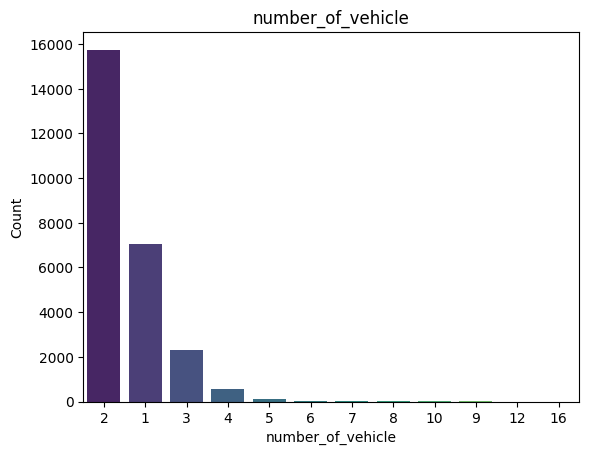

In [ ]:
# Create the countplot
plot_manoeuvre = sns.countplot(x=trainset["number_of_vehicles"], palette="viridis", order=trainset["number_of_vehicles"].value_counts().index)

# Rotate x-axis labels if they are too long
plt.xticks()

# Set the axis labels
plot_manoeuvre.set_xlabel("number_of_vehicle")
plot_manoeuvre.set_ylabel("Count")

# Set the title (optional)
plot_manoeuvre.set_title("number_of_vehicle")

# Display the plot
plt.show()

<Axes: xlabel='age_of_driver', ylabel='Count'>

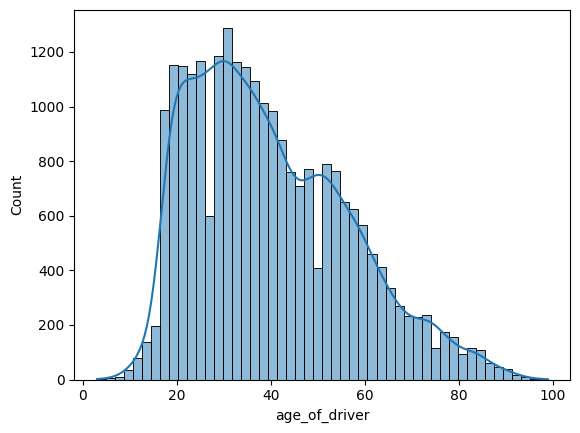

In [ ]:
sns.histplot(trainset["age_of_driver"],kde=True, bins = 50)

<Axes: ylabel='count'>

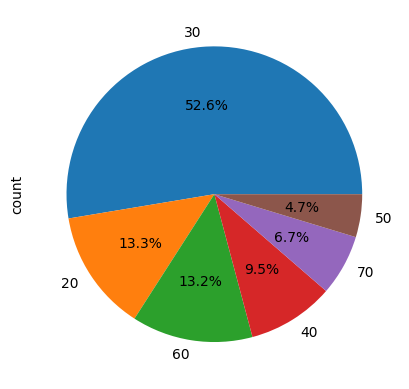

In [ ]:
trainset["speed_limit"].value_counts().plot(kind="pie", autopct='%1.1f%%', rot=0)

<Axes: xlabel='speed_limit', ylabel='Count'>

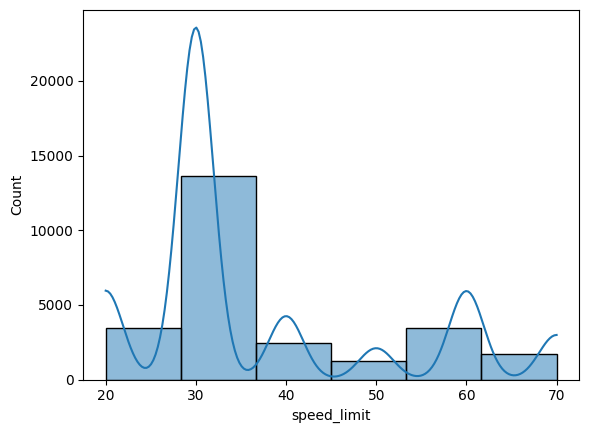

In [ ]:
sns.histplot(trainset["speed_limit"],kde=True, bins = 6)

52.6% of accidents regardless of severity are at areas with 30 MPH speed limit, while 60 MPH and 70 MPH speed limit areas are responsible for 13.2% and 6.7% of all accidents respectively.

<ipython-input-38-9b3552a6669e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_journey = sns.countplot(x=trainset["journey_purpose_of_driver"], palette="viridis", order=trainset["journey_purpose_of_driver"].value_counts().index)


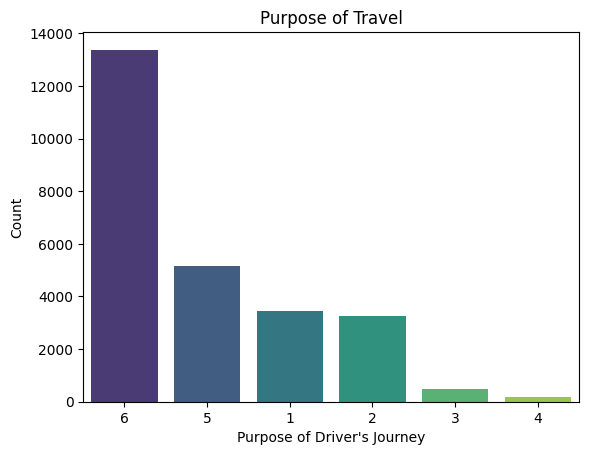

In [ ]:
# Create the countplot
plot_journey = sns.countplot(x=trainset["journey_purpose_of_driver"], palette="viridis", order=trainset["journey_purpose_of_driver"].value_counts().index)

# Rotate x-axis labels if they are too long
plt.xticks()

# Set the axis labels
plot_journey.set_xlabel("Purpose of Driver's Journey")
plot_journey.set_ylabel("Count")

# Set the title (optional)
plot_journey.set_title("Purpose of Travel")

# Display the plot
plt.show()

Key:

1: Journey as part of work | 2: Journey to work | 3: Taking pupils to/from school/home | 4: Pupil riding to/from school/home | 5: other | 6: unknown | 15: other/ not known | -1: Missing data |

51.6% of accidents have unknown causes. 19.9% of cases are recorded as "other". This could be due to accident severity or just personal preference of not sharing the information. 25.9% of accidents are caused as part of driving for work or driving to work. and only 2.7% of all accidents are while pupils are on the vehicles going from/to school/home, this could mean drivers tend to be more careful when pupils are in the vehicle. the arbitrary numbering can be changed for clarity

In [ ]:
selected_vehicle_types = [ 9, 19, 3, 1, 5, 8, 2, 4]

In [ ]:
trainset["vehicle_type"].value_counts()

vehicle_type
9.0     17302
1.0      2918
3.0      1636
19.0     1061
5.0       623
11.0      525
8.0       410
90.0      392
4.0       336
2.0       189
21.0      132
97.0       88
10.0       63
23.0       57
22.0       55
98.0       54
20.0       39
16.0       15
17.0       14
18.0        4
99.0        3
Name: count, dtype: int64

Not alot of data for certain vehicle types, we will be dropping them later on.

<ipython-input-41-2dcc64867312>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_pie['vehicle_type'] = filtered_df_pie['vehicle_type'].map(vehicle_type_labels)


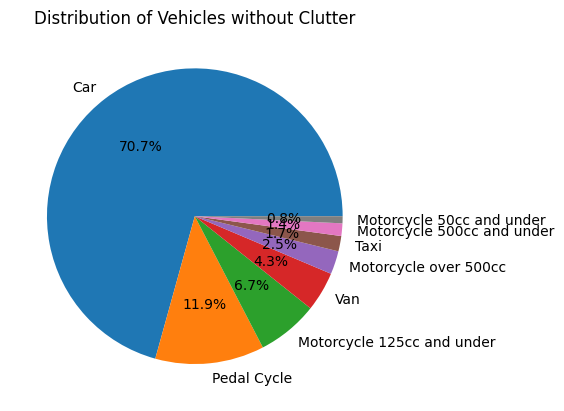

In [ ]:
# Define the mapping from numeric values to labels
vehicle_type_labels = {
    1: 'Pedal Cycle',
    2: 'Motorcycle 50cc and under',
    3: 'Motorcycle 125cc and under',
    4: 'Motorcycle 500cc and under',
    5: 'Motorcycle over 500cc',
    8: 'Taxi',
    9: 'Car',
    19: 'Van'
}

# Filter the DataFrame for specific vehicle types
selected_vehicle_types = [1, 2, 3, 4, 5, 8, 9, 19]
filtered_df_pie = trainset[trainset['vehicle_type'].isin(selected_vehicle_types)]

# Map the vehicle_type to its label
filtered_df_pie['vehicle_type'] = filtered_df_pie['vehicle_type'].map(vehicle_type_labels)

# Plot the pie chart with labels
filtered_df_pie['vehicle_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=filtered_df_pie['vehicle_type'].value_counts().index, rot=0)
plt.ylabel('')
plt.title('Distribution of Vehicles without Clutter')
plt.show()

Piechart showing the proportion of the vehicles in the dataset which make up 92.4% of the entire data

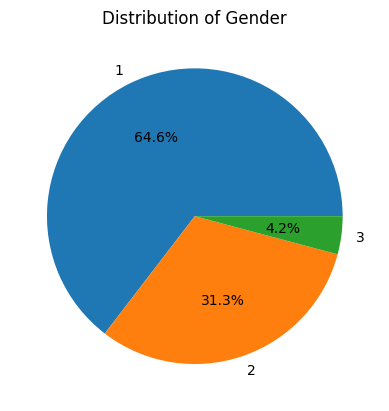

In [ ]:
trainset["sex_of_driver"].value_counts().plot(kind="pie", autopct='%1.1f%%', rot=0)
plt.ylabel('')  # This removes the default ylabel
plt.title('Distribution of Gender')  # Add a title to the pie chart
plt.show()

KEY:

1 = Male, 2 = Female, 3 = No data.

Majority 64.6% of accidents are caused by males, wwhile only 31.3% are caused by females. there is also 4.2% of missing gender data in the dataset.

<Axes: ylabel='count'>

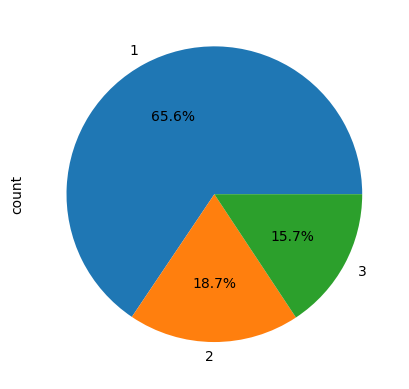

In [ ]:
trainset["casualty_class"].value_counts().plot(kind="pie", autopct='%1.1f%%', rot=0)

Majority of the injuries are class 1 which is driver or rider(bike), while 18.7% are the passengers, and 15.7% are pedestrians.

<Axes: ylabel='count'>

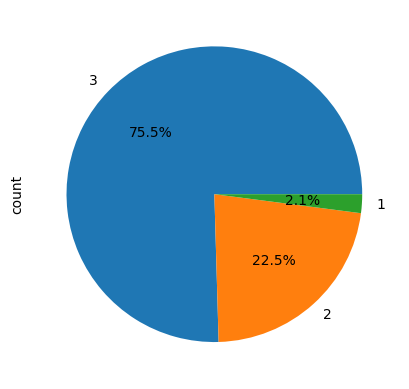

In [ ]:
trainset["accident_severity"].value_counts().plot(kind="pie", autopct='%1.1f%%', rot=0)

Key:

1: Fatal | 2: Serious | 3: Slight |

75.5% of all accidents are minor injuries, while 22.5% are serious and 2.1% have been fatal.

<Axes: ylabel='count'>

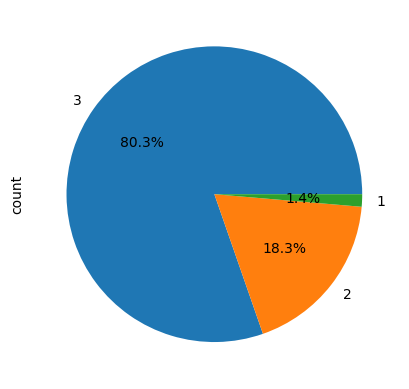

In [ ]:
trainset["casualty_severity"].value_counts().plot(kind="pie", autopct='%1.1f%%', rot=0)

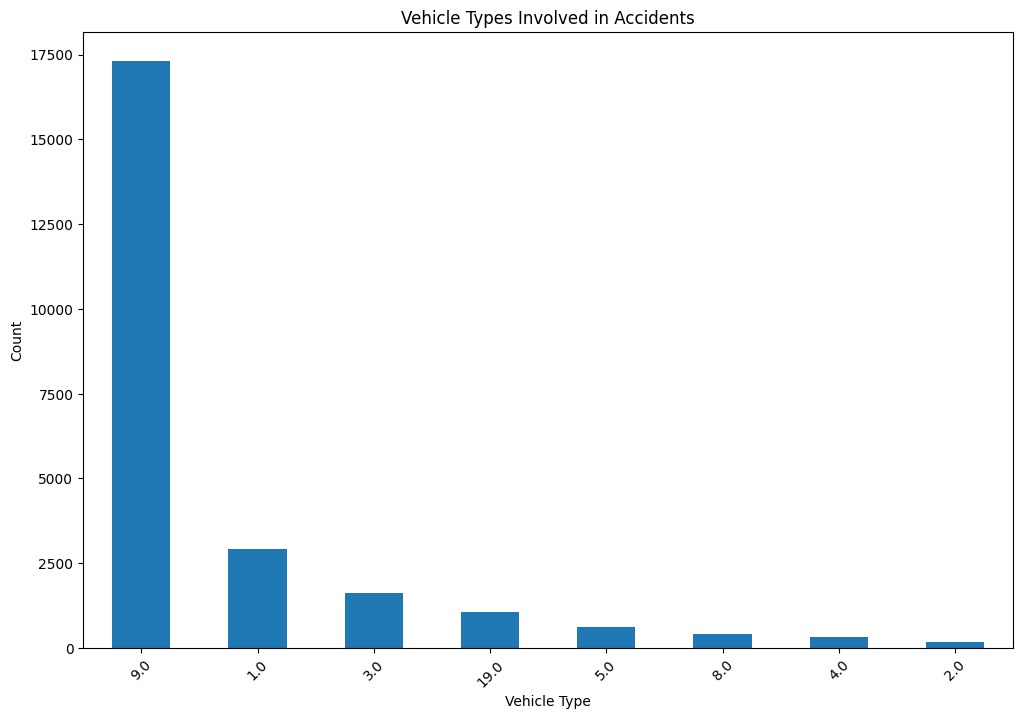

In [ ]:
# Filter the DataFrame for specific vehicle types
vehicle_types_to_plot = [1, 2, 3, 4, 5, 8, 9, 19]
filtered_df = trainset[trainset['vehicle_type'].isin(vehicle_types_to_plot)]

# Plot the value counts of the specified vehicle types
plt.figure(figsize=(12, 8))  # Bigger figure size to display graph correctly
filtered_df['vehicle_type'].value_counts().plot(kind='bar', rot=45)
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.title('Vehicle Types Involved in Accidents')
plt.show()

In [ ]:
trainset["vehicle_manoeuvre"].value_counts()

vehicle_manoeuvre
18.0    13559
9.0      1824
99.0     1723
4.0      1509
3.0      1235
17.0     1089
5.0      1022
16.0      849
7.0       663
13.0      391
2.0       387
1.0       298
10.0      293
14.0      246
15.0      169
12.0      150
11.0      107
8.0       101
6.0        78
Name: count, dtype: int64

Key:

0: Pedestrian | 9: Car | 1: Cyclist | 3: Motorcylces 125cc and under | 19: Van

Majority of accidents are cars 14204 records

<ipython-input-48-40ecebef4356>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_junction = sns.countplot(x=trainset["junction_location"], palette="viridis", order=trainset["junction_location"].value_counts().index)


Text(0.5, 1.0, 'Location of Junction')

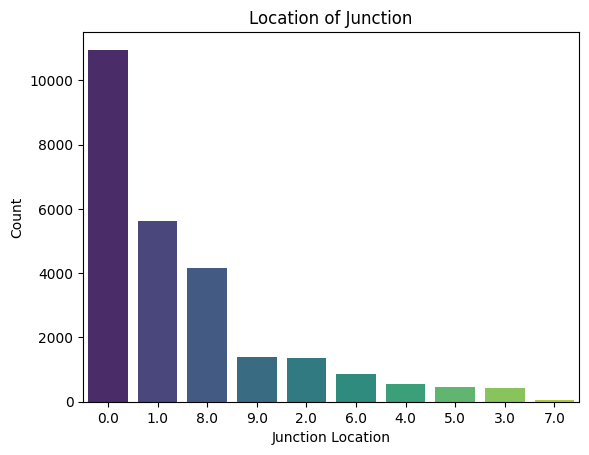

In [ ]:
# Create the countplot
plot_junction = sns.countplot(x=trainset["junction_location"], palette="viridis", order=trainset["junction_location"].value_counts().index)

# Rotate x-axis labels if they are too long
plt.xticks()

# Set the axis labels
plot_junction.set_xlabel("Junction Location")
plot_junction.set_ylabel("Count")

# Set the title (optional)
plot_junction.set_title("Location of Junction")

# Display the plot

Majority of incidents occurred with a junction not within 20m. and a good portion within roundabouts, and the third most occurring near private entrances or driveways.

# **Bi-variate Analysis**

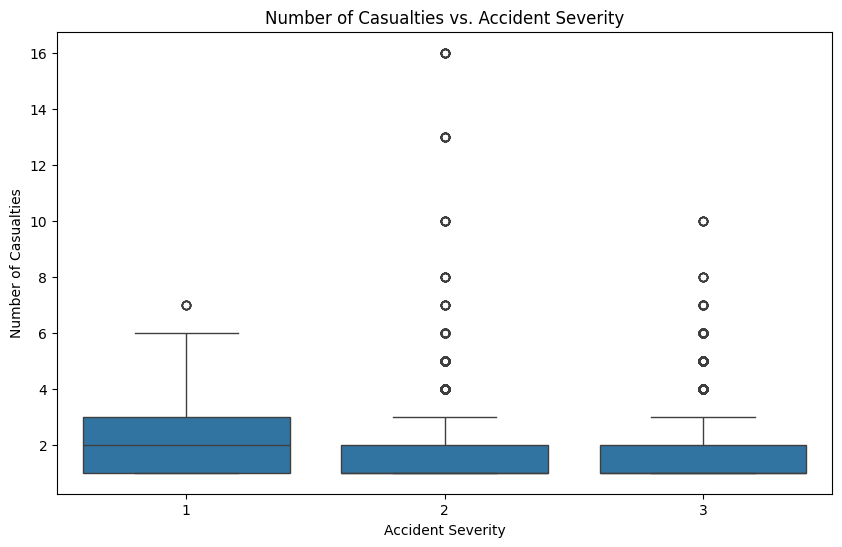

In [ ]:
# Function to create a boxplot
def create_boxplot(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x, y=y, data=trainset)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


#  Number of Casualties vs. Accident Severity
create_boxplot('accident_severity', 'number_of_casualties', 'Number of Casualties vs. Accident Severity', 'Accident Severity', 'Number of Casualties')

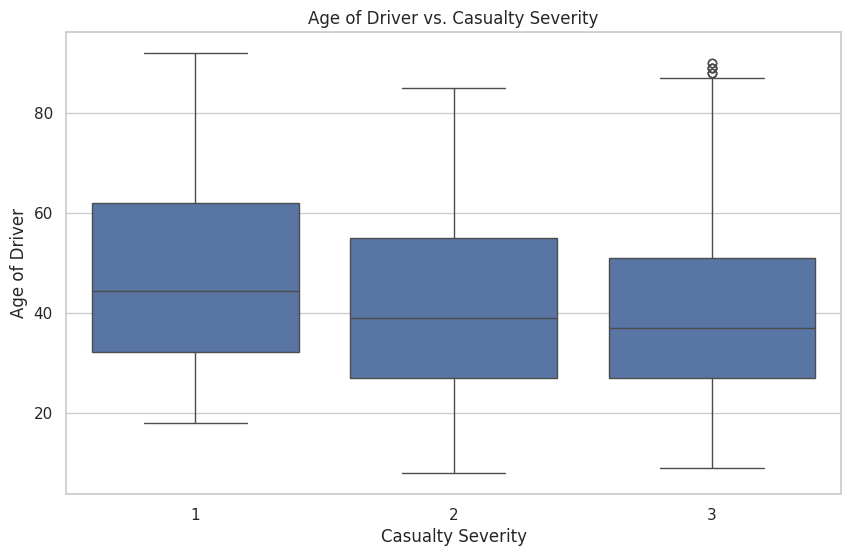

In [ ]:
# Sample the DataFrame (10% of the data)
sampled_df1 = trainset.sample(frac=0.1)

# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# 1. Age of Driver vs. Casualty Severity
plt.figure(figsize=(10, 6))
sns.boxplot(x='casualty_severity', y='age_of_driver', data=sampled_df1)
plt.title('Age of Driver vs. Casualty Severity')
plt.xlabel('Casualty Severity')
plt.ylabel('Age of Driver')
plt.show()


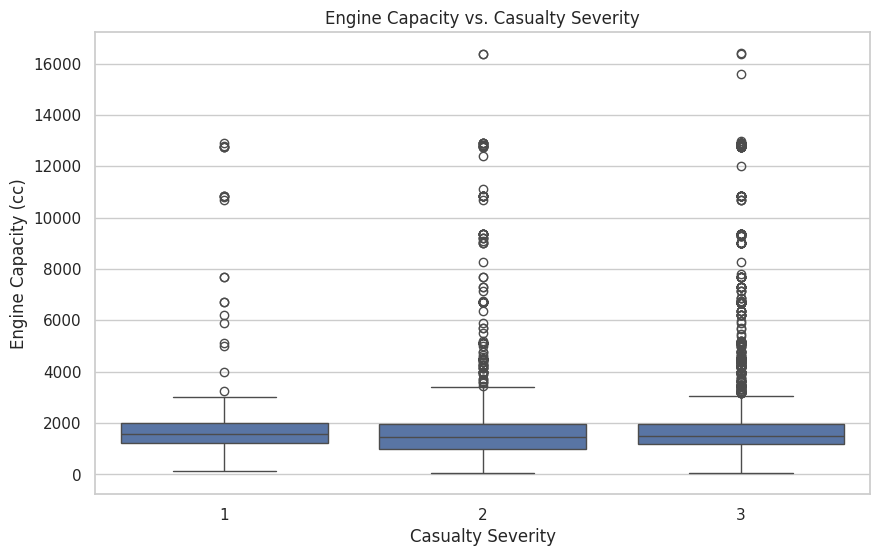

In [ ]:
# 2. Engine Capacity vs. Casualty Severity
plt.figure(figsize=(10, 6))
sns.boxplot(x='casualty_severity', y='engine_capacity_cc', data=trainset)
plt.title('Engine Capacity vs. Casualty Severity')
plt.xlabel('Casualty Severity')
plt.ylabel('Engine Capacity (cc)')
plt.show()

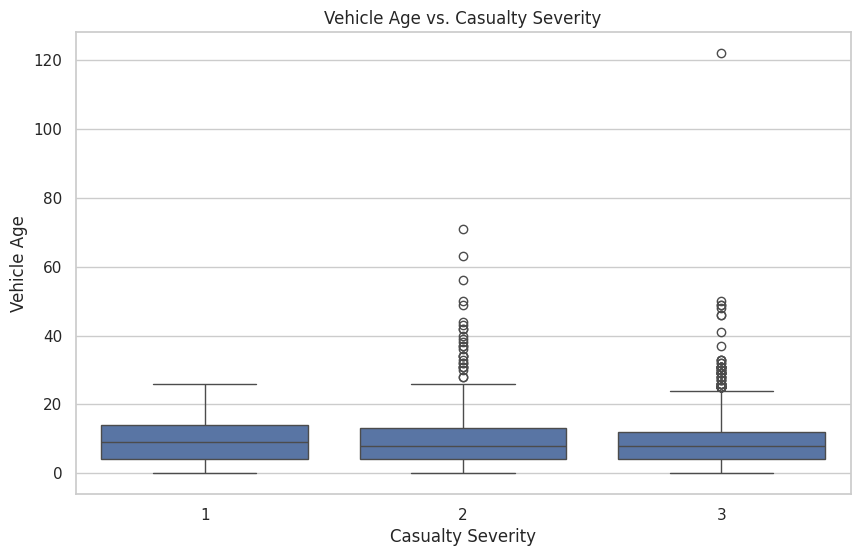

In [ ]:
# 3. Vehicle Age vs. Casualty Severity
plt.figure(figsize=(10, 6))
sns.boxplot(x='casualty_severity', y='age_of_vehicle', data=trainset)
plt.title('Vehicle Age vs. Casualty Severity')
plt.xlabel('Casualty Severity')
plt.ylabel('Vehicle Age')
plt.show()

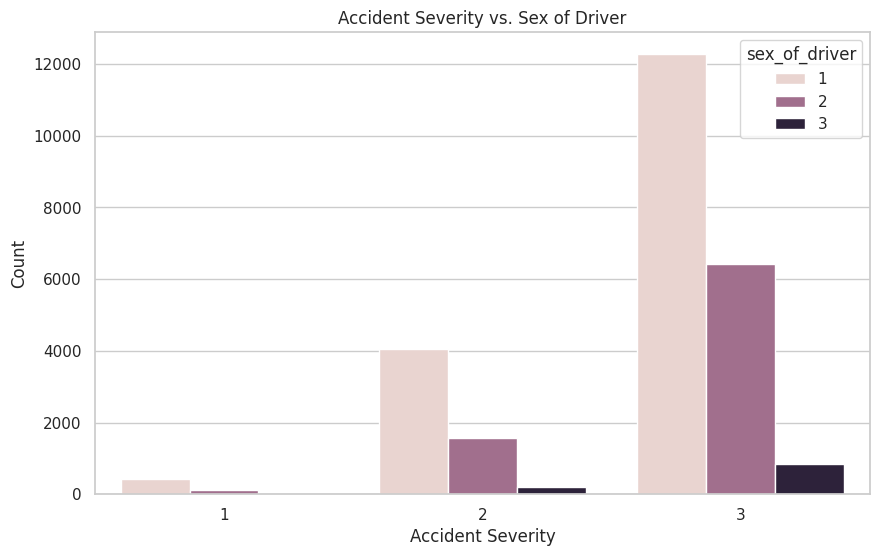

In [ ]:
# 2. Accident Severity vs. Sex of Driver
# Function to create a countplot
def create_countplot(x, hue, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=x, hue=hue, data=trainset)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

create_countplot('accident_severity', 'sex_of_driver', 'Accident Severity vs. Sex of Driver', 'Accident Severity', 'Count')

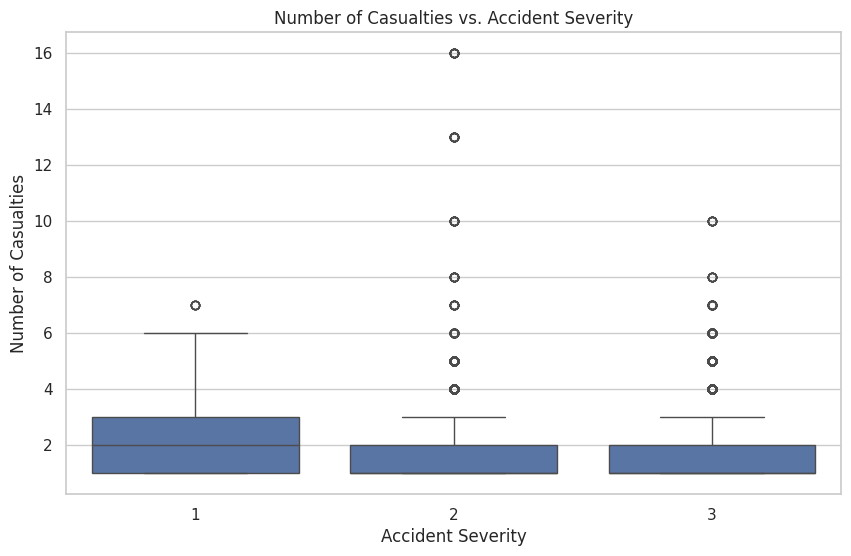

In [ ]:
#  Number of Casualties vs. Accident Severity
create_boxplot('accident_severity', 'number_of_casualties', 'Number of Casualties vs. Accident Severity', 'Accident Severity', 'Number of Casualties')

In [ ]:
age_band = trainset
age_band["age_band_of_driver"] = pd.cut(trainset['age_of_driver'], bins=[0, 18, 25, 35, 50, 65, 100], labels=['<18', '18-24', '25-34', '35-49', '50-64', '65+'])

<ipython-input-56-0c0b0157f1eb>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_col, y=y_col, data=data, palette=palette)


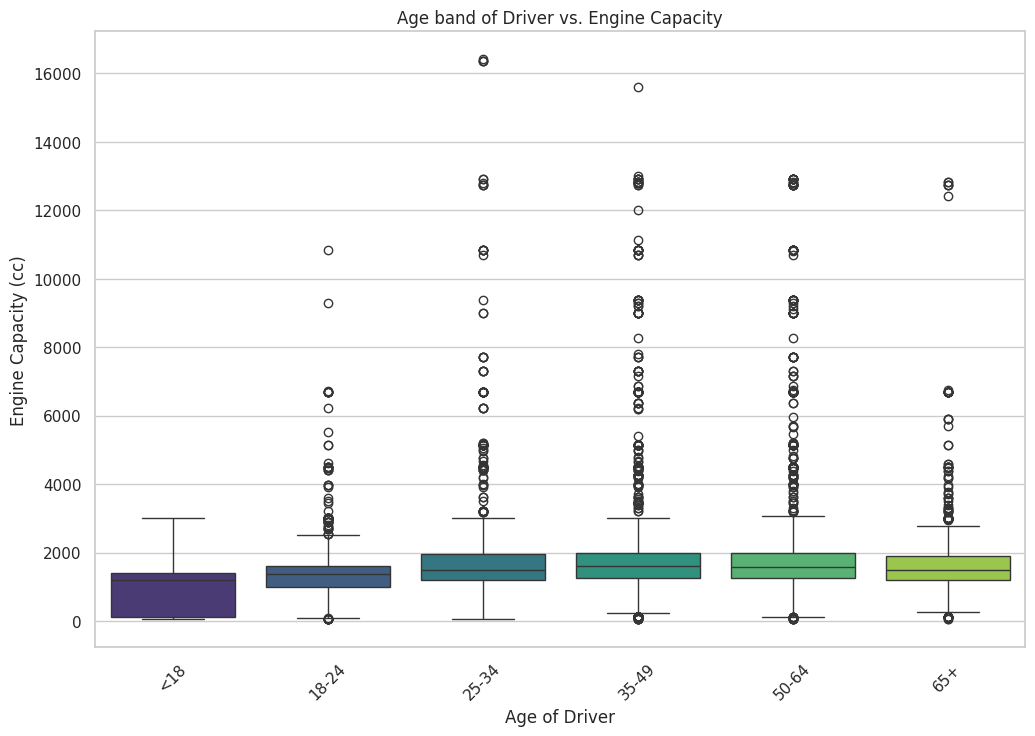

In [ ]:
# Boxplot for Age of Driver vs. Engine Capacity
def create_improved_boxplot(x_col, y_col, title, xlabel, ylabel, data, palette):
    """
    Function to create an improved boxplot.

    Parameters:
    x_col (str): Column name for the x-axis.
    y_col (str): Column name for the y-axis.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    data (DataFrame): The DataFrame containing the data.
    palette (str): Color palette for the plot.
    """
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=x_col, y=y_col, data=data, palette=palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

create_improved_boxplot('age_band_of_driver', 'engine_capacity_cc', 'Age band of Driver vs. Engine Capacity', 'Age of Driver', 'Engine Capacity (cc)', age_band , 'viridis')



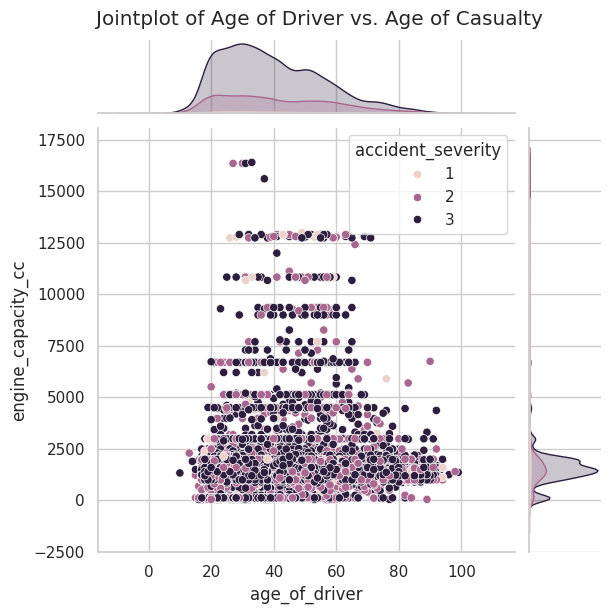

In [ ]:
sns.jointplot(data=trainset, x='age_of_driver', y='engine_capacity_cc', kind='scatter', hue='accident_severity')
plt.suptitle('Jointplot of Age of Driver vs. Age of Casualty', y=1.02)
plt.show()

# **Multivariate analysis**

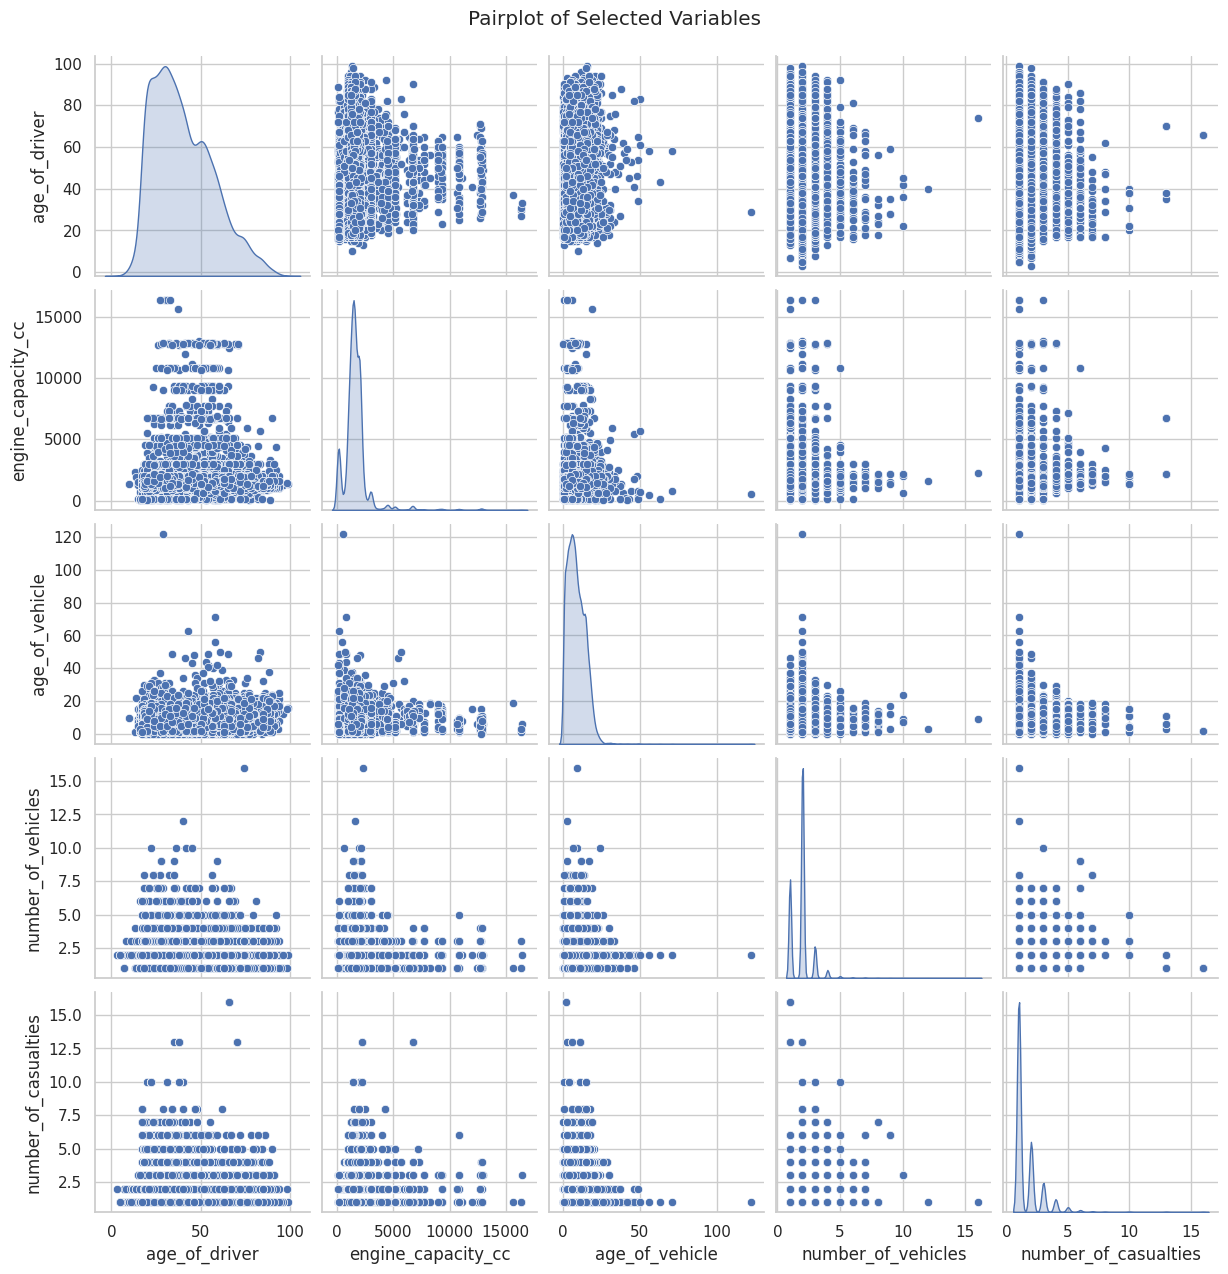

In [ ]:
# Pairplot to visualize pairwise relationships
sns.pairplot(trainset[[ 'age_of_driver', 'engine_capacity_cc', 'age_of_vehicle', 'number_of_vehicles', 'number_of_casualties']], diag_kind='kde')
plt.suptitle('Pairplot of Selected Variables', y=1.02)
plt.show()

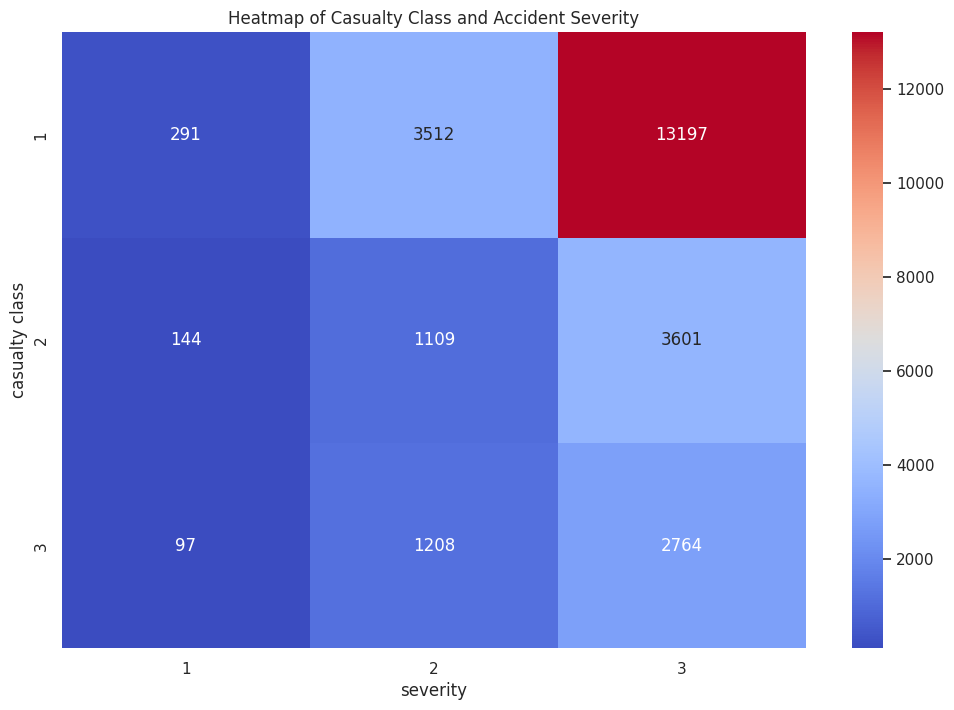

In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(trainset['casualty_class'], trainset['accident_severity'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title('Heatmap of Casualty Class and Accident Severity')
plt.xlabel('severity')
plt.ylabel('casualty class')
plt.show()

# **5. data preprocessing**

  **5.1. Feature engineering**

In [ ]:
#Drop the 'engine_capacity_cc' and 'age_of_vehicle' columns, and age_band_of_driver as it was only for graphing
trainset = trainset.drop(['engine_capacity_cc', 'age_of_vehicle', 'age_band_of_driver'], axis=1)
testset = testset.drop(['engine_capacity_cc', 'age_of_vehicle'], axis=1)

In [ ]:
# Filter the dataset to only keep specific vehicle types
allowed_vehicle_types = [1, 2, 3, 4, 5, 8, 9, 19]
trainset = trainset[trainset['vehicle_type'].isin(allowed_vehicle_types)]

Selecting the types of vehicles that are making up the most of the data.

In [ ]:
#do the same on testset
testset = testset[testset['vehicle_type'].isin(allowed_vehicle_types)]

In [ ]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24475 entries, 40439 to 119634
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   accident_severity          24475 non-null  int64  
 1   age_of_driver              23262 non-null  float64
 2   sex_of_driver              24475 non-null  int64  
 3   vehicle_type               24475 non-null  float64
 4   vehicle_manoeuvre          24265 non-null  float64
 5   vehicle_direction_from     24095 non-null  float64
 6   vehicle_direction_to       24094 non-null  float64
 7   junction_location          24386 non-null  float64
 8   speed_limit                24475 non-null  int64  
 9   road_surface_conditions    24345 non-null  float64
 10  journey_purpose_of_driver  24475 non-null  int64  
 11  casualty_class             24475 non-null  int64  
 12  junction_detail            24475 non-null  int64  
 13  driver_imd_decile          21740 non-null  flo

In [ ]:
trainset['accident_severity'].value_counts()

accident_severity
3    18597
2     5384
1      494
Name: count, dtype: int64

# **5.2. Missing value**

In [ ]:
# Impute 'age_of_driver' with the mean value from the training set to avoid data leakage
mean_imputer = SimpleImputer(strategy='mean')
trainset['age_of_driver'] = mean_imputer.fit_transform(trainset[['age_of_driver']])
testset['age_of_driver'] = mean_imputer.transform(testset[['age_of_driver']])

In [ ]:
 #Impute missing values in 'driver_imd_decile',"driver_home_area_type" with median of trainset
iterative_imputer = IterativeImputer(max_iter=20)
trainset['driver_imd_decile'] = iterative_imputer.fit_transform(trainset[['driver_imd_decile']])
testset['driver_imd_decile'] = iterative_imputer.transform(testset[['driver_imd_decile']])
trainset["driver_home_area_type"] = iterative_imputer.fit_transform(trainset[["driver_home_area_type"]])
testset["driver_home_area_type"] = iterative_imputer.transform(testset[["driver_home_area_type"]])

In [ ]:
# List of columns to convert to integers
columns_to_convert = [
    'accident_severity', 'age_of_driver', 'sex_of_driver', 'vehicle_type',
    'vehicle_manoeuvre', 'vehicle_direction_from', 'vehicle_direction_to',
    'junction_location', 'speed_limit', 'road_surface_conditions',
    'journey_purpose_of_driver', 'casualty_class', 'junction_detail',
    'driver_imd_decile', 'driver_home_area_type'
]

# Impute missing values with the median value of each column for trainset and testset
imputer = SimpleImputer(strategy='median')
trainset[columns_to_convert] = imputer.fit_transform(trainset[columns_to_convert])
testset[columns_to_convert] = imputer.transform(testset[columns_to_convert])

# Convert the columns to integers
trainset[columns_to_convert] = trainset[columns_to_convert].astype(int)
testset[columns_to_convert] = testset[columns_to_convert].astype(int)

In [ ]:
trainset.isnull().sum()

accident_severity            0
age_of_driver                0
sex_of_driver                0
vehicle_type                 0
vehicle_manoeuvre            0
vehicle_direction_from       0
vehicle_direction_to         0
junction_location            0
speed_limit                  0
road_surface_conditions      0
journey_purpose_of_driver    0
casualty_class               0
junction_detail              0
driver_imd_decile            0
driver_home_area_type        0
number_of_vehicles           0
number_of_casualties         0
casualty_severity            0
dtype: int64

In [ ]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24475 entries, 40439 to 119634
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   accident_severity          24475 non-null  int64
 1   age_of_driver              24475 non-null  int64
 2   sex_of_driver              24475 non-null  int64
 3   vehicle_type               24475 non-null  int64
 4   vehicle_manoeuvre          24475 non-null  int64
 5   vehicle_direction_from     24475 non-null  int64
 6   vehicle_direction_to       24475 non-null  int64
 7   junction_location          24475 non-null  int64
 8   speed_limit                24475 non-null  int64
 9   road_surface_conditions    24475 non-null  int64
 10  journey_purpose_of_driver  24475 non-null  int64
 11  casualty_class             24475 non-null  int64
 12  junction_detail            24475 non-null  int64
 13  driver_imd_decile          24475 non-null  int64
 14  driver_home_area_type 

In [ ]:
trainset.head()

,accident_severity,age_of_driver,sex_of_driver,vehicle_type,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,junction_location,speed_limit,road_surface_conditions,journey_purpose_of_driver,casualty_class,junction_detail,driver_imd_decile,driver_home_area_type,number_of_vehicles,number_of_casualties,casualty_severity
40439,2,75,1,9,4,1,5,0,30,1,5,1,0,4,1,2,2,3
82126,3,66,1,9,3,5,5,1,30,1,5,2,1,1,1,4,3,3
120670,2,18,2,9,18,1,5,1,60,2,5,2,6,6,1,2,4,3
125445,3,77,1,5,12,7,3,0,70,1,1,1,0,4,1,1,1,3
88101,3,40,1,9,4,7,3,0,20,1,6,1,0,1,1,2,1,3


**5.3. Dummy variables**


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Create OneHotEncoder instance without dropping any column
one_hot_encoder = OneHotEncoder(drop=None, sparse_output=False)

In [ ]:
# categorical columns to transform
cat_cols = ["vehicle_type", "sex_of_driver", "vehicle_manoeuvre",'vehicle_direction_from','vehicle_direction_to',
            'junction_location','road_surface_conditions','road_surface_conditions','journey_purpose_of_driver',
          'casualty_class' ,'junction_detail']

# fit an encoder and transform the **trainset**
cat_vals = trainset[cat_cols]
cat_vals

,vehicle_type,sex_of_driver,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,junction_location,road_surface_conditions,road_surface_conditions,journey_purpose_of_driver,casualty_class,junction_detail
40439,9,1,4,1,5,0,1,1,5,1,0
82126,9,1,3,5,5,1,1,1,5,2,1
120670,9,2,18,1,5,1,2,2,5,2,6
125445,5,1,12,7,3,0,1,1,1,1,0
88101,9,1,4,7,3,0,1,1,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5699,1,1,99,9,9,9,1,1,2,1,3
43783,9,1,9,1,7,8,2,2,6,2,3
68077,3,1,18,6,2,8,1,1,6,1,2
104217,9,2,18,3,7,0,1,1,5,1,0


In [ ]:
transformed = one_hot_encoder.fit_transform(cat_vals)
transformed

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# the names of the new columns
new_col_names = one_hot_encoder.get_feature_names_out(cat_cols)
new_col_names

array(['vehicle_type_1', 'vehicle_type_2', 'vehicle_type_3',
       'vehicle_type_4', 'vehicle_type_5', 'vehicle_type_8',
       'vehicle_type_9', 'vehicle_type_19', 'sex_of_driver_1',
       'sex_of_driver_2', 'sex_of_driver_3', 'vehicle_manoeuvre_1',
       'vehicle_manoeuvre_2', 'vehicle_manoeuvre_3',
       'vehicle_manoeuvre_4', 'vehicle_manoeuvre_5',
       'vehicle_manoeuvre_6', 'vehicle_manoeuvre_7',
       'vehicle_manoeuvre_8', 'vehicle_manoeuvre_9',
       'vehicle_manoeuvre_10', 'vehicle_manoeuvre_11',
       'vehicle_manoeuvre_12', 'vehicle_manoeuvre_13',
       'vehicle_manoeuvre_14', 'vehicle_manoeuvre_15',
       'vehicle_manoeuvre_16', 'vehicle_manoeuvre_17',
       'vehicle_manoeuvre_18', 'vehicle_manoeuvre_99',
       'vehicle_direction_from_0', 'vehicle_direction_from_1',
       'vehicle_direction_from_2', 'vehicle_direction_from_3',
       'vehicle_direction_from_4', 'vehicle_direction_from_5',
       'vehicle_direction_from_6', 'vehicle_direction_from_7',
       '

In [ ]:
trainset.head()

,accident_severity,age_of_driver,sex_of_driver,vehicle_type,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,junction_location,speed_limit,road_surface_conditions,journey_purpose_of_driver,casualty_class,junction_detail,driver_imd_decile,driver_home_area_type,number_of_vehicles,number_of_casualties,casualty_severity
40439,2,75,1,9,4,1,5,0,30,1,5,1,0,4,1,2,2,3
82126,3,66,1,9,3,5,5,1,30,1,5,2,1,1,1,4,3,3
120670,2,18,2,9,18,1,5,1,60,2,5,2,6,6,1,2,4,3
125445,3,77,1,5,12,7,3,0,70,1,1,1,0,4,1,1,1,3
88101,3,40,1,9,4,7,3,0,20,1,6,1,0,1,1,2,1,3


In [ ]:
# put the transformed data as columns in the trainset dataframe
for i, new_col_name in enumerate(new_col_names):
    trainset[new_col_name] = transformed[:,i]

# check if the dummies are produced correctly in the trainset
trainset.head()

<ipython-input-76-969ecd3de025>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trainset[new_col_name] = transformed[:,i]
<ipython-input-76-969ecd3de025>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trainset[new_col_name] = transformed[:,i]
<ipython-input-76-969ecd3de025>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n

,accident_severity,age_of_driver,sex_of_driver,vehicle_type,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,junction_location,speed_limit,road_surface_conditions,...,junction_detail_0,junction_detail_1,junction_detail_2,junction_detail_3,junction_detail_5,junction_detail_6,junction_detail_7,junction_detail_8,junction_detail_9,junction_detail_99
40439,2,75,1,9,4,1,5,0,30,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82126,3,66,1,9,3,5,5,1,30,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120670,2,18,2,9,18,1,5,1,60,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
125445,3,77,1,5,12,7,3,0,70,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88101,3,40,1,9,4,7,3,0,20,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# delete the original categorical columns
trainset = trainset.drop(cat_cols, axis=1)

In [ ]:
# transform the **testset** using the encoder fitted on trainset
cat_vals = testset[cat_cols]
transformed = one_hot_encoder.transform(cat_vals)

# put the transformed data as columns in the testset dataframe
for i, new_col_name in enumerate(new_col_names):
    testset[new_col_name] = transformed[:,i]

# check if the dummies are produced correctly in the testset
testset.head()

<ipython-input-78-950e93f53736>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  testset[new_col_name] = transformed[:,i]
<ipython-input-78-950e93f53736>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  testset[new_col_name] = transformed[:,i]
<ipython-input-78-950e93f53736>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

,accident_severity,age_of_driver,sex_of_driver,vehicle_type,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,junction_location,speed_limit,road_surface_conditions,...,junction_detail_0,junction_detail_1,junction_detail_2,junction_detail_3,junction_detail_5,junction_detail_6,junction_detail_7,junction_detail_8,junction_detail_9,junction_detail_99
58749,2,61,1,9,9,4,2,8,40,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29671,3,39,3,9,16,5,1,0,40,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70287,2,61,1,3,18,4,8,1,60,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
59354,3,23,2,9,9,7,4,5,30,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
70556,2,48,1,1,18,1,6,1,30,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# delete the original categorical columns
testset = testset.drop(cat_cols, axis=1)

In [ ]:
# separate the target and predictors
ytrain = trainset["accident_severity"].copy()
Xtrain = trainset.drop("accident_severity", axis=1)
ytest = testset["accident_severity"].copy()
Xtest = testset.drop("accident_severity", axis=1)

In [ ]:
# Specify columns to remove to ensure no multicollinearity_ degree of freedom
columns_to_remove = ['junction_detail_99', 'sex_of_driver_3', 'vehicle_manoeuvre_99'
, 'junction_location_9', 'vehicle_direction_to_9','vehicle_direction_from_9'
,'road_surface_conditions_9','journey_purpose_of_driver_6']

# Remove the specified columns
Xtrain.drop(columns=columns_to_remove, inplace=True)
Xtest.drop(columns=columns_to_remove, inplace=True)

In [ ]:
Xtrain.head()

,age_of_driver,speed_limit,driver_imd_decile,driver_home_area_type,number_of_vehicles,number_of_casualties,casualty_severity,vehicle_type_1,vehicle_type_2,vehicle_type_3,...,casualty_class_3,junction_detail_0,junction_detail_1,junction_detail_2,junction_detail_3,junction_detail_5,junction_detail_6,junction_detail_7,junction_detail_8,junction_detail_9
40439,75,30,4,1,2,2,3,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82126,66,30,1,1,4,3,3,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120670,18,60,6,1,2,4,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
125445,77,70,4,1,1,1,3,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88101,40,20,1,1,2,1,3,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**5.4. Outlier**

In [ ]:
# check the size of the Xtrain and Xtest datasets
Xtrain.shape, Xtest.shape

((24475, 84), (6110, 84))

In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=100, random_state=0, contamination=0.05).fit(Xtrain)
yhat = clf.predict(Xtrain)
Xtrain = Xtrain[yhat != -1]
ytrain = ytrain[yhat != -1]
Xtrain.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(23251, 84)

In [ ]:
yhat = clf.predict(Xtest)
Xtest = Xtest[yhat == 1]
ytest = ytest[yhat != -1]
Xtest.shape

(5822, 84)

**5.5 Log transformation**

Here, we do Log transformation for our numerical data in order to reduce skewness and stabilise variance.

array([[<Axes: title={'center': 'age_of_driver'}>]], dtype=object)

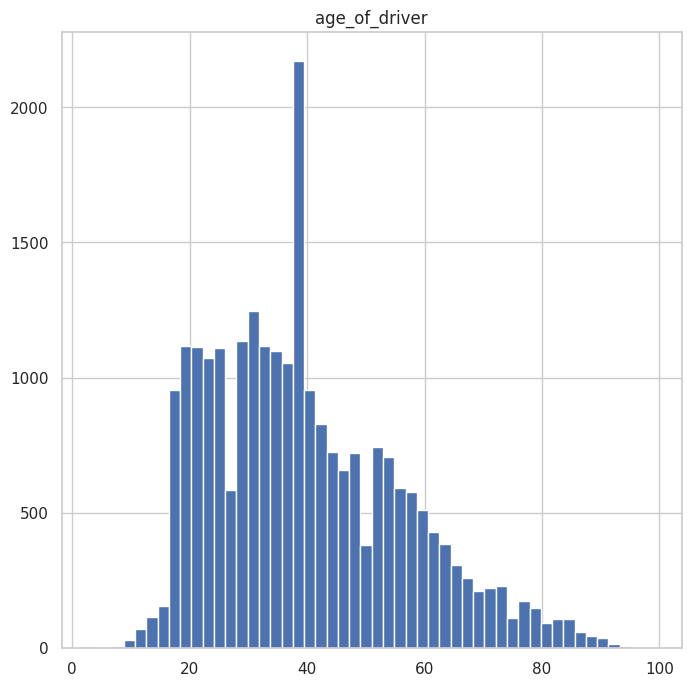

In [ ]:
trainset[["age_of_driver"]].hist(bins=50, figsize=(8,8))

In [ ]:
for col in ["age_of_driver"]:
    trainset.loc[:, col] = np.log(trainset.loc[:, col] + 1)
    testset.loc[:, col] = np.log(testset.loc[:, col] + 1)

array([[<Axes: title={'center': 'age_of_driver'}>]], dtype=object)

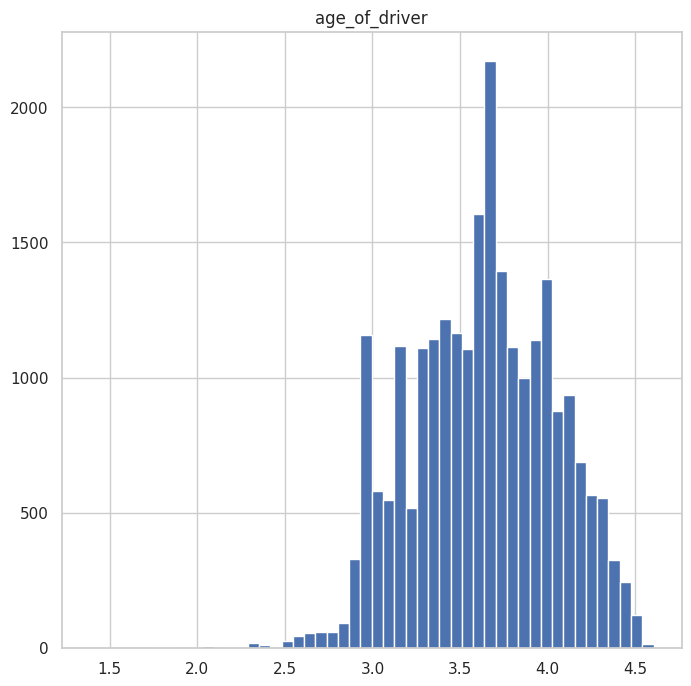

In [ ]:
trainset[["age_of_driver", ]].hist(bins=50, figsize=(8,8))

In [ ]:
Xtrain.head()

,age_of_driver,speed_limit,driver_imd_decile,driver_home_area_type,number_of_vehicles,number_of_casualties,casualty_severity,vehicle_type_1,vehicle_type_2,vehicle_type_3,...,casualty_class_3,junction_detail_0,junction_detail_1,junction_detail_2,junction_detail_3,junction_detail_5,junction_detail_6,junction_detail_7,junction_detail_8,junction_detail_9
40439,75,30,4,1,2,2,3,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82126,66,30,1,1,4,3,3,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120670,18,60,6,1,2,4,3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
125445,77,70,4,1,1,1,3,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88101,40,20,1,1,2,1,3,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**5.6. Feature selection**

Using recurrent feature elimination to select top 25 feature with the greatest correlation with the target

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression

In [ ]:
selector = SelectKBest(r_regression, k=25)
Xtrain = selector.fit_transform(Xtrain, ytrain)
Xtest = selector.transform(Xtest)

In [ ]:
# fit_transform returns a NumPy array, so we need to put it back
# into a Pandas dataframe
Xtrain = pd.DataFrame(Xtrain, columns=selector.get_feature_names_out())
Xtest = pd.DataFrame(Xtest, columns=selector.get_feature_names_out())

**5.7. Feature scaling**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit_transform returns a NumPy array, so we need to put it back
# into a Pandas dataframe
scaled_vals = scaler.fit_transform(Xtrain)
Xtrain = pd.DataFrame(scaled_vals, columns=Xtrain.columns)

# inspect the data
Xtrain.head()

,number_of_vehicles,casualty_severity,vehicle_type_3,vehicle_type_8,vehicle_type_9,sex_of_driver_2,vehicle_manoeuvre_3,vehicle_manoeuvre_4,vehicle_manoeuvre_5,vehicle_manoeuvre_8,...,junction_location_8,road_surface_conditions_1,road_surface_conditions_4,journey_purpose_of_driver_1,journey_purpose_of_driver_2,casualty_class_1,junction_detail_1,junction_detail_2,junction_detail_3,junction_detail_6
0,0.113726,0.464916,-0.271571,-0.110604,0.629781,-0.685295,-0.214091,4.029359,-0.189134,-0.062683,...,-0.434538,0.688075,-0.139847,-0.336106,-0.387758,0.682653,-0.267809,-0.121638,-0.606321,-0.334201
1,2.775258,0.464916,-0.271571,-0.110604,0.629781,-0.685295,4.670917,-0.248178,-0.189134,-0.062683,...,-0.434538,0.688075,-0.139847,-0.336106,-0.387758,-1.464873,3.734006,-0.121638,-0.606321,-0.334201
2,0.113726,0.464916,-0.271571,-0.110604,0.629781,1.459226,-0.214091,-0.248178,-0.189134,-0.062683,...,-0.434538,-1.453330,-0.139847,-0.336106,-0.387758,-1.464873,-0.267809,-0.121638,-0.606321,2.992213
3,-1.217041,0.464916,-0.271571,-0.110604,-1.587853,-0.685295,-0.214091,-0.248178,-0.189134,-0.062683,...,-0.434538,0.688075,-0.139847,2.975251,-0.387758,0.682653,-0.267809,-0.121638,-0.606321,-0.334201
4,0.113726,0.464916,-0.271571,-0.110604,0.629781,-0.685295,-0.214091,4.029359,-0.189134,-0.062683,...,-0.434538,0.688075,-0.139847,-0.336106,-0.387758,0.682653,-0.267809,-0.121638,-0.606321,-0.334201


In [ ]:
scaled_vals = scaler.transform(Xtest)
Xtest = pd.DataFrame(scaled_vals, columns=Xtest.columns)
Xtest.head()

,number_of_vehicles,casualty_severity,vehicle_type_3,vehicle_type_8,vehicle_type_9,sex_of_driver_2,vehicle_manoeuvre_3,vehicle_manoeuvre_4,vehicle_manoeuvre_5,vehicle_manoeuvre_8,...,junction_location_8,road_surface_conditions_1,road_surface_conditions_4,journey_purpose_of_driver_1,journey_purpose_of_driver_2,casualty_class_1,junction_detail_1,junction_detail_2,junction_detail_3,junction_detail_6
0,0.113726,0.464916,-0.271571,-0.110604,0.629781,-0.685295,-0.214091,-0.248178,-0.189134,-0.062683,...,2.301296,0.688075,-0.139847,-0.336106,-0.387758,0.682653,-0.267809,-0.121638,-0.606321,-0.334201
1,-1.217041,0.464916,-0.271571,-0.110604,0.629781,-0.685295,-0.214091,-0.248178,-0.189134,-0.062683,...,-0.434538,-1.453330,-0.139847,-0.336106,-0.387758,-1.464873,-0.267809,-0.121638,-0.606321,-0.334201
2,0.113726,-1.879427,3.682278,-0.110604,-1.587853,-0.685295,-0.214091,-0.248178,-0.189134,-0.062683,...,-0.434538,0.688075,-0.139847,2.975251,-0.387758,0.682653,-0.267809,-0.121638,1.649291,-0.334201
3,2.775258,0.464916,-0.271571,-0.110604,0.629781,1.459226,-0.214091,-0.248178,-0.189134,-0.062683,...,-0.434538,0.688075,-0.139847,-0.336106,-0.387758,0.682653,-0.267809,-0.121638,1.649291,-0.334201
4,0.113726,-1.879427,-0.271571,-0.110604,-1.587853,-0.685295,-0.214091,-0.248178,-0.189134,-0.062683,...,-0.434538,0.688075,-0.139847,-0.336106,-0.387758,0.682653,-0.267809,-0.121638,1.649291,-0.334201


In [ ]:
trainset = Xtrain.copy()
trainset['accident_severity'] = ytrain.values
testset = Xtest.copy()
testset['accident_severity'] = ytest.values
# Export to CSV
trainset.to_csv("trainsetroad.csv", index=False)
testset.to_csv("testsetroad.csv", index=False)